The virtual machine contains multiple datasets in `csv` files as well as stored in a `postgresql` server.

## Connecting to Postgresql 

Firstly, import the python modules we want to use..

In [117]:
import sqlalchemy as sql
import pandas as pd
import matplotlib.pyplot as plt

### Install python packages

If you don't have this module installed, you can open the terminal and install via:
```
sudo apt update
sudo apt install python3-pip
pip3 install sqlachemy pandas matplotlib
```

### Connect to a database
Give the ip address of the VirtualBox, if you are running these from inside the VirtualBox there you want to just use :

In [118]:
ip_address = 'localhost' #or 127.0.0.1

If you have exposed the VirtualBox to your local network, or even the web, then specify that IP address

In [3]:
ip_address = '192.168.0.104'

Create an engine that connects to the postgres database that runs inside the VirtualBox

In [4]:
ngin = sql.create_engine(f'postgresql://etldev:etldev@{ip_address}:5432/postgres')

Establish a connection to it:

In [5]:
cnx = ngin.connect()

### Inspecting the databases and datasets

We can use the inspector to see what databases (schemas) are available to use

In [6]:
inspector = sql.inspect(ngin)
[schema for schema in inspector.get_schema_names() ]

['information_schema',
 'omop_vocabulary',
 'public',
 'synthea_etl',
 'synthea_omop',
 'synthea_omop_results',
 'synthea_raw']

Picking the raw "synthea" data, we can see what datasets (tables) are contained within the `synthea_raw` database:

In [7]:
inspector.get_table_names(schema='synthea_raw')

['allergies',
 'careplans',
 'conditions',
 'devices',
 'encounters',
 'imaging_studies',
 'immunizations',
 'observations',
 'organizations',
 'patients',
 'payer_transitions',
 'medications',
 'payers',
 'procedures',
 'providers',
 'supplies']

## SQL to Pandas Dataframe

Using a quick function we can load the full table into a `pandas` dataframe and print what is given by the first 'row' of the table.

In [28]:
def get_df(schema_name,table_name):
    selection = r'''
SELECT
*
FROM %s.%s
'''%(schema_name,table_name)

    return pd.read_sql(selection,ngin)

df_conditions = get_df('synthea_raw','conditions')
df_conditions.iloc[0]

start                                      2001-07-09
stop                                             None
patient          0e517b72-2d1f-47f5-be31-ebf777539755
encounter        6d0fcf84-4411-478f-b4e4-fba643da0e61
code                                        128613002
description                          Seizure disorder
load_table_id                              conditions
load_row_id                                         1
Name: 0, dtype: object

### Displaying a Dataframe

By using `set_index()` we can organise the table a bit better to display the data for each patient. Using `drop()` we can remove the unnessary column `load_table_id` which is just `conditions` for all data entries.

In [31]:
df_conditions = df_conditions.set_index(['patient','encounter','code']).drop('load_table_id',axis=1)
df_conditions

start  \
patient                              encounter                            code                    
0e517b72-2d1f-47f5-be31-ebf777539755 6d0fcf84-4411-478f-b4e4-fba643da0e61 128613002  2001-07-09   
                                                                          703151001  2001-07-09   
                                     9156490c-ccef-40a0-bba7-a27b4691e333 84757009   2001-09-10   
                                     e670e3f9-067f-43da-8444-c4d236b002ce 40055000   2006-04-02   
4773cd3e-f603-4ef7-8088-4c75bc9b5259 def28c54-0b05-4171-99b3-2da43460d7b3 162864005  1947-03-31   
...                                                                                         ...   
51c0750a-e2db-4e4f-b8d3-9e9d572dfb41 bc44e5e2-6ae0-4e17-9074-838f5c39c3ab 68962001   2020-02-28   
                                                                          57676002   2020-02-28   
                                                                          36955009   2020-02-28   
                                                                          840544004  2020-02-28   
                                                                          840539006  2020-02-28   

                                                                                           stop  \
patient                              encounter                            code                    
0e517b72-2d1f-47f5-be31-ebf777539755 6d0fcf84-4411-478f-b4e4-fba643da0e61 128613002        None   
                                                                          703151001        None   
                                     9156490c-ccef-40a0-bba7-a27b4691e333 84757009         None   
                                     e670e3f9-067f-43da-8444-c4d236b002ce 40055000         None   
4773cd3e-f603-4ef7-8088-4c75bc9b5259 def28c54-0b05-4171-99b3-2da43460d7b3 162864005        None   
...                                                                                         ...   
51c0750a-e2db-4e4f-b8d3-9e9d572dfb41 bc44e5e2-6ae0-4e17-9074-838f5c39c3ab 68962001   2020-03-29   
                                                                          57676002   2020-03-29   
                                                                          36955009   2020-03-29   
                                                                          840544004  2020-02-28   
                                                                          840539006  2020-03-29   

                                                                                                                 description  \
patient                              encounter                            code                                                 
0e517b72-2d1f-47f5-be31-ebf777539755 6d0fcf84-4411-478f-b4e4-fba643da0e61 128613002                         Seizure disorder   
                                                                          703151001    History of single seizure (situation)   
                                     9156490c-ccef-40a0-bba7-a27b4691e333 84757009                                  Epilepsy   
                                     e670e3f9-067f-43da-8444-c4d236b002ce 40055000              Chronic sinusitis (disorder)   
4773cd3e-f603-4ef7-8088-4c75bc9b5259 def28c54-0b05-4171-99b3-2da43460d7b3 162864005  Body mass index 30+ - obesity (finding)   
...                                                                                                                      ...   
51c0750a-e2db-4e4f-b8d3-9e9d572dfb41 bc44e5e2-6ae0-4e17-9074-838f5c39c3ab 68962001                     Muscle pain (finding)   
                                                                          57676002                      Joint pain (finding)   
                                                                          36955009                   Loss of taste (finding)   
                                                                          840544004                       

### Inspecting a Series

We can look at the column (or series) for `description` and count the number of unique values (number of times this was a registered condition). Using `head(10)` we can display the top 10 ranked conditions that appear.

In [107]:
df_conditions['description'].value_counts().head(10)

Viral sinusitis (disorder)                 1284
Suspected COVID-19                          911
COVID-19                                    881
Fever (finding)                             804
Acute viral pharyngitis (disorder)          709
Cough (finding)                             622
Acute bronchitis (disorder)                 580
Normal pregnancy                            516
Body mass index 30+ - obesity (finding)     489
Loss of taste (finding)                     440
Name: description, dtype: int64

### Filtering a DataFrame

Next, we use filter the dataframe into just two columns: the start (date) and description of the condition.  
We also call two additional functions:
1. `pd.to_datetime()` helps by converting the date from a string into an datetime object
2. `sort_values()` helps by ordering the column based on the date

In [ ]:
df_small = df_conditions.reset_index()[['start','description']]
df_small['start'] = pd.to_datetime(df_small['start'])
df_small = df_small.sort_values('start')
df_small

We are able to filter the to an even smaller dataframe by requiring the date of `start` to be from 2019 onwards

In [112]:
df_small_from_2019 = df_small[df_small['start'] > '2019']
df_small_from_2019

,start,description
13354,2019-01-02,Fracture of ankle
2039,2019-01-03,Acute bronchitis (disorder)
5072,2019-01-03,Viral sinusitis (disorder)
11537,2019-01-04,Acute bronchitis (disorder)
1929,2019-01-04,Cardiac Arrest
...,...,...
7351,2020-06-11,Viral sinusitis (disorder)
5037,2020-06-11,Neuropathy due to type 2 diabetes mellitus (di...
195,2020-06-14,Normal pregnancy
14300,2020-06-14,Sprain of ankle


We make a series of new dataframes by filtering based on the description

In [115]:
df_viral = df_small_from_2019[df_small_from_2019['description'].str.contains('Viral')]
df_pregnancy = df_small_from_2019[df_small_from_2019['description'].str.contains('pregnancy')]
len(df_viral),len(df_pregnancy)

(180, 66)

Further splitting up a dataframe for COVID-19 cases into confirmed and suspected cases

In [116]:
df_covid = df_small_from_2019[df_small_from_2019['description'].str.contains('covid',case=False)]

df_suspected_covid = df_covid[df_covid['description'].str.contains('Suspected')]
df_confirmed_covid = df_covid[df_covid['description'].str.contains('Suspected') == 0 ]

len(df_covid),len(df_suspected_covid),len(df_confirmed_covid)

(1792, 911, 881)

### Plotting Data

We can now use `matplotlib` to make histograms showing the number of cases of various filtered conditions as a function of the start date.

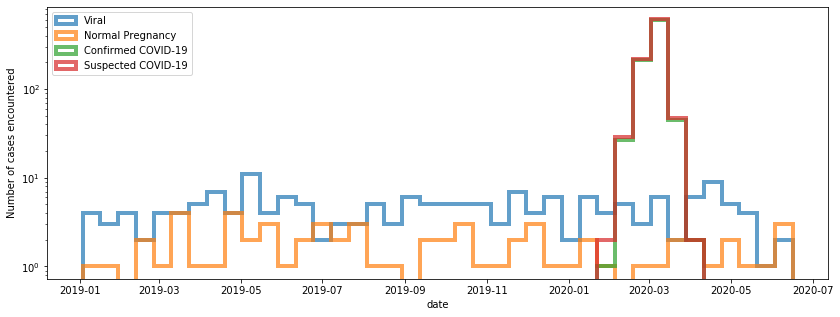

In [113]:
fig,ax = plt.subplots(1,figsize=(14,5))

_,bins,_ = ax.hist(df_viral['start'],bins=40,label='Viral',
                   lw=4,histtype='step')
ax.hist(df_pregnancy['start'],bins=bins,label='Normal Pregnancy',
        lw=4,histtype='step')
ax.hist(df_confirmed_covid['start'],bins=bins,label='Confirmed COVID-19',
        lw=4,histtype='step')
ax.hist(df_suspected_covid['start'],bins=bins,label='Suspected COVID-19',
        lw=4,histtype='step')

ax.set_yscale('log')
ax.set_ylabel('Number of cases encountered')
ax.set_xlabel('date')
plt.legend(loc='upper left')
plt.show();